# Installs and Download Demo data

**IMPORTANT** 
Restart the kernel after first installation to avoid this error:

`ImportError: cannot import name '_png' from 'matplotlib'`

In [1]:
!pip install -q gdown nannyml

## Download Data Drift Module and Demo Data

In [2]:
import gdown

# Data Drift Module FROZEN version 28/12/2022 - can also be taken from:
# !git clone https://github.com/mryanivtal/mlops.git
!gdown 1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
!unzip -n mlops-main.zip
# !cp -n /content/drive/MyDrive/2023/S1/3690_MLOPs/mlops_project/POCs/mlops-main.zip . && 

# Sample dataset CSV file for the Demo
!gdown 1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
!gdown 1VfGsdyLDy2hEJKKIPWP6OTkvj5B5cbel
!gdown 1jSmwH1ysTdhWEe1KyB7f2xxegpGXda5P


Downloading...
From: https://drive.google.com/uc?id=1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
To: /content/mlops-main.zip
100% 770k/770k [00:00<00:00, 117MB/s]
Archive:  mlops-main.zip
1f2d7b564efc99302b08e3ab0602abbe5caa023b
Downloading...
From: https://drive.google.com/uc?id=1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
To: /content/boston_housing.csv
100% 305k/305k [00:00<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VfGsdyLDy2hEJKKIPWP6OTkvj5B5cbel
To: /content/boston_housing_small.csv
100% 35.2k/35.2k [00:00<00:00, 33.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jSmwH1ysTdhWEe1KyB7f2xxegpGXda5P
To: /content/motor_claims.csv
100% 2.62M/2.62M [00:00<00:00, 143MB/s]


# Imports

In [3]:
%load_ext autoreload
%autoreload 2

# generic 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split

import os
import sys 
import random
sys.path.append('mlops-main/data_drift/')
sys.path.append('mlops-main/data_drift/drift_detection/')
sys.path.append('mlops-main/data_drift/helpers/')

# data drift specific
# from boston_ds import BostonDS
import helpers.pipeline_utils as plutils
from helpers.utils import calc_perf_kpis
from helpers.model_helper import XgbModel
from helpers.data_helper import sample_from_data,change_int_values
from drift_detection.drift_detector import DriftDetector
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester

SEED=42
np.random.seed(SEED)

# Load dataset configuration for Data Drift Simulator

To changethe dataset update the "selected_dataset" in the next cell.

In [4]:
selected_dataset = 'BOSTON'
# selected_dataset = 'CLAIMS'
if(selected_dataset=='BOSTON'):
  config_file = 'mlops-main/data_drift/boston_config.json'
  columns_to_modify = ['CRIM','RM','LSTAT','CHAS']
  ds_categ_noise_factor = 0.2
  ds_numeric_noise_factor = 1.5
elif(selected_dataset=='CLAIMS'):
  config_file = 'mlops-main/data_drift/french_motor_claims_config.json'
  columns_to_modify = ['IDpol', 'Exposure', 'DrivAge', 'BonusMalus', 'LogDensity','VehPower', 'VehAge', 'Area_A']
  ds_categ_noise_factor = 0.4
  ds_numeric_noise_factor = 2.5
else:
  print('Please set a configuration file to load in \'config_file\'')
  assert(False)

In [5]:
config_dict = plutils.load_configuration(config_file=config_file,verbose=True)

Loading configuration from: mlops-main/data_drift/boston_config.json
********************************************************************************
Key=dataset_name,Value=Boston Housing
Key=dataset_csv_path,Value=boston_housing.csv
Key=cat_features,Value=['CHAS']
Key=int_features,Value=['RAD', 'TAX']
Key=cont_features,Value=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']
Key=target_label,Value=PRICE
********************************************************************************


# Load dataset and Train Test Split

In [6]:
df_full=pd.read_csv(config_dict['dataset_csv_path'])
df_full.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.070457,18.0,2.31,0,0.538650,6.575,64.759142,4.093071,1,296,15.3,396.90,4.98,24.0
1,0.058989,0.0,7.07,0,0.469597,6.421,79.430377,4.963156,2,242,17.8,396.90,9.14,21.6
2,-0.091092,0.0,7.07,0,0.468406,7.185,61.133471,4.985532,2,242,17.8,392.83,4.03,34.7
3,-0.082456,0.0,2.18,0,0.458138,6.998,45.571149,6.060382,3,222,18.7,394.63,2.94,33.4
4,0.037007,0.0,2.18,0,0.458367,7.147,54.259141,6.073643,3,222,18.7,396.90,5.33,36.2


In [7]:
# ============================================================= Initial data setup
x_cat_features  = config_dict['cat_features']
x_int_features  = config_dict['int_features']
x_cont_features = config_dict['cont_features']
y_label         = config_dict['target_label']

X = df_full.drop(y_label,axis=1).copy()
y = df_full[y_label]
print(X.shape,y.shape)
# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 550 #1200 takes 1:26 min / With 2000 #each test 2 min / with 500 45 seconds
X_sample, y_sample = sample_from_data(X, y, TRAIN_TEST_SIZE)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.4, random_state=SEED)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(2530, 13) (2530,)


((330, 13), (330,), (220, 13), (220,))

In [8]:
display(X_train.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
650,2.676325,0.0,19.58,0,0.871062,4.903,98.137272,1.346214,5,403,14.7,396.90,29.29
1659,1.661833,0.0,21.89,0,0.622956,5.019,99.901438,1.425090,4,437,21.2,396.90,34.41
2295,0.142035,20.0,6.96,0,0.463894,6.240,16.372986,4.406564,3,223,18.6,396.90,6.59
2378,-0.013700,80.0,1.91,0,0.412401,5.663,21.512180,10.578604,4,334,22.0,382.80,8.05
873,13.660149,0.0,18.10,0,0.631267,3.863,99.896429,1.527568,24,666,20.2,131.42,13.33


# Main Demo Flow Utility

Prerequisites:

1. Load dataset configuration

2. Load dataset

3. Train and Evaluate a baseline reference model and baseline production model

4. Create and train Automatic Drift Detectors

Demo flow:

5. Run flow with detection and witout retraining

6. Run flow with detection and retraining

In [9]:
# ============================================================= Runtime step
def run_drift_demo(X,y,number_of_batches = 300, start_drift_at_batch = 100,
                   sample_size = 50,columns_to_modify=[],
                   production_model=None,drift_detector=None,perf_kpis_prod=None,
                   baseline_model=None,baseline_drift_detector=None,perf_kpis_base=None,
                   retrain_on_drift=False,noise_factor=0.01,x_cat_features=[],
                   numeric_noise_factor=1.5):
  '''
  Runs inference in batches, while adding noise to the data to simulate drift
  Checks for data drift and evaluates the given models
  If a baseline model is given both models are being evaluated
  '''
  X_copy = X.copy()
  y_copy = y.copy()
  X_samples = None
  y_samples = None

  # Runtime loop
  # Sample batch from data (No drift yet)
  for i in tqdm(range(number_of_batches)):
      X_sample, y_sample = sample_from_data(X_copy, y_copy, sample_size)
      
      if X_samples is None:
          X_samples = X_sample.copy()
          y_samples = y_sample.copy()

      # modify data batch to create feature drift
      # gradual apply of drift      
      if (i > start_drift_at_batch):
        columns_to_modify_tmp = columns_to_modify.copy()
        if(i>start_drift_at_batch):
          columns_to_modify_tmp = columns_to_modify_tmp[1:] # 2 noisy 
          X_sample = plutils.add_artificial_noise_to_data(X_copy,X_sample,i,
                                                          columns_to_modify_tmp,
                                                          x_cat_features,
                                                          start_drift_at_batch,
                                                          noise_factor=ds_categ_noise_factor,
                                                          numeric_noise_factor=ds_numeric_noise_factor)
        if(i>3*start_drift_at_batch):
          columns_to_modify_tmp = columns_to_modify_tmp # 3 noisy 
          X_sample = plutils.add_artificial_noise_to_data(X_copy,X_sample,i,
                                                          columns_to_modify_tmp,
                                                          x_cat_features,
                                                          start_drift_at_batch,
                                                          noise_factor=ds_categ_noise_factor,
                                                          numeric_noise_factor=ds_numeric_noise_factor)
      #save all samples for analysis
      X_samples = X_samples.append(X_sample)
      y_samples = y_samples.append(y_sample)

      # predict
      y_pred = production_model.predict(X_sample)

      # calc RMSE (For demo only, cannot do in real runtime - no labels there
      kpi_sample = calc_perf_kpis(X_sample, y_sample, y_pred)

      # Execute drift test on batch (prod model)
      drift_test_results = drift_detector.test_drift(X_sample)
      kpi_sample['drift_detected'] = drift_test_results['drift_detected']
      kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
      kpi_sample['retrain'] = False

      #Check for drift 
      if((retrain_on_drift) and (drift_test_results['drift_detected'])):
          # retraining...due to drift
          production_model = XGBRegressor(objective='reg:squarederror')
          # add the new "data" to the training
          #add the same noise of the sample to the entire dataset
          production_model.fit(X_sample, y_sample)
          drift_detector.fit(X_sample,reset_history=False)           
          kpi_sample['retrain'] = True

      perf_kpis_prod = perf_kpis_prod.append(kpi_sample, ignore_index=True)

      # For comparison of two models predict on the same sample (!!!)
      y_pred_base = baseline_model.predict(X_sample)
      kpi_sample_base = calc_perf_kpis(X_sample, y_sample, y_pred_base)

      # Execute drift test on batch (baseline model)
      drift_test_results_base = baseline_drift_detector.test_drift(X_sample)
      kpi_sample_base['drift_detected'] = drift_test_results_base['drift_detected']
      kpi_sample_base['test_exceptions'] = drift_test_results_base['test_exceptions']
      perf_kpis_base = perf_kpis_base.append(kpi_sample_base, ignore_index=True)
    
  return drift_detector,perf_kpis_prod,baseline_drift_detector,perf_kpis_base,X_samples,y_samples


# Runtime 1 - Inference Drift Detection (no retraining)

In [10]:
%%time

# Init fresh start
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,baseline_model,production_model = \
            plutils.init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,_,_ = \
      run_drift_demo(X,y,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model,drift_detector=drift_detector,perf_kpis_prod=perf_kpis_prod,
                   baseline_model=baseline_model,baseline_drift_detector=base_drift_detector,perf_kpis_base=perf_kpis_base,
                   noise_factor=ds_categ_noise_factor,numeric_noise_factor=ds_numeric_noise_factor,x_cat_features=x_cat_features)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 44.2 s, sys: 689 ms, total: 44.9 s
Wall time: 49.4 s


## Plot RMSE for Baseline vs. Production

Here they are identical
Drift detected but not handled

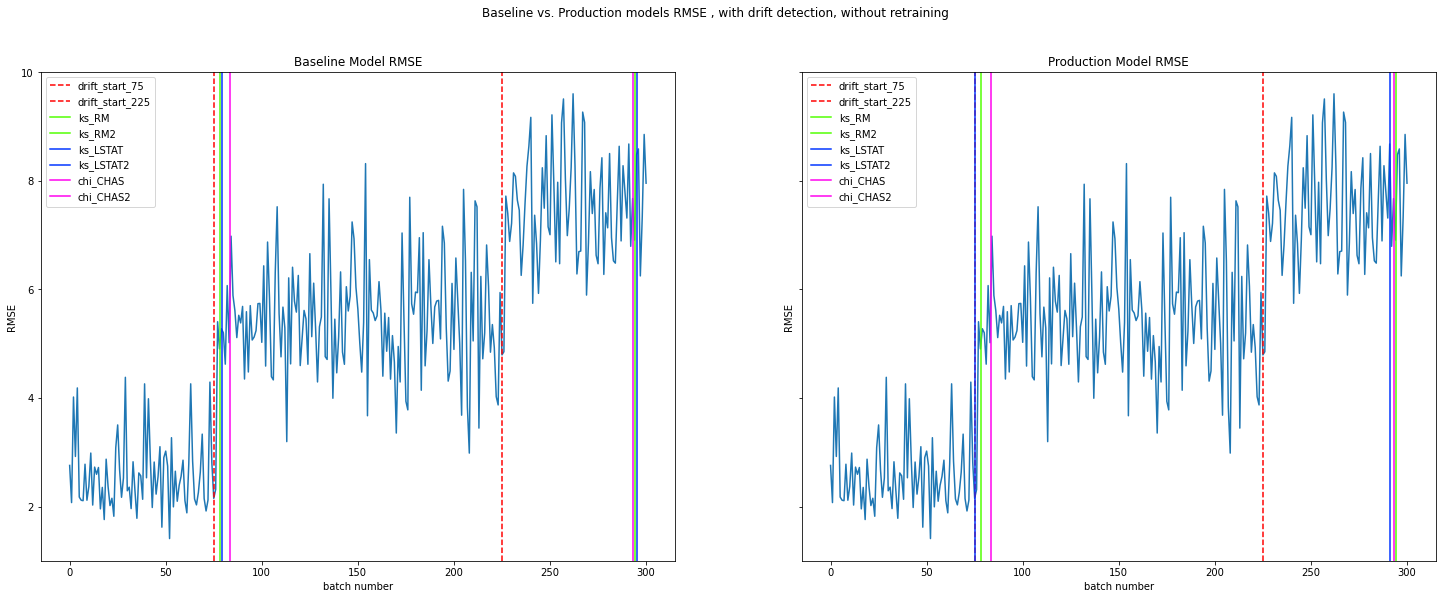

In [11]:
fig, axs = plt.subplots(1,2,figsize=(25, 9),sharey=True)
plutils.display_run(perf_kpis_base,base_drift_detector,start_drift_at_batch,axs[0],title='Baseline Model RMSE',smoothen=False)
plutils.display_run(perf_kpis_prod,drift_detector,start_drift_at_batch,axs[1],title='Production Model RMSE',smoothen=False)
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

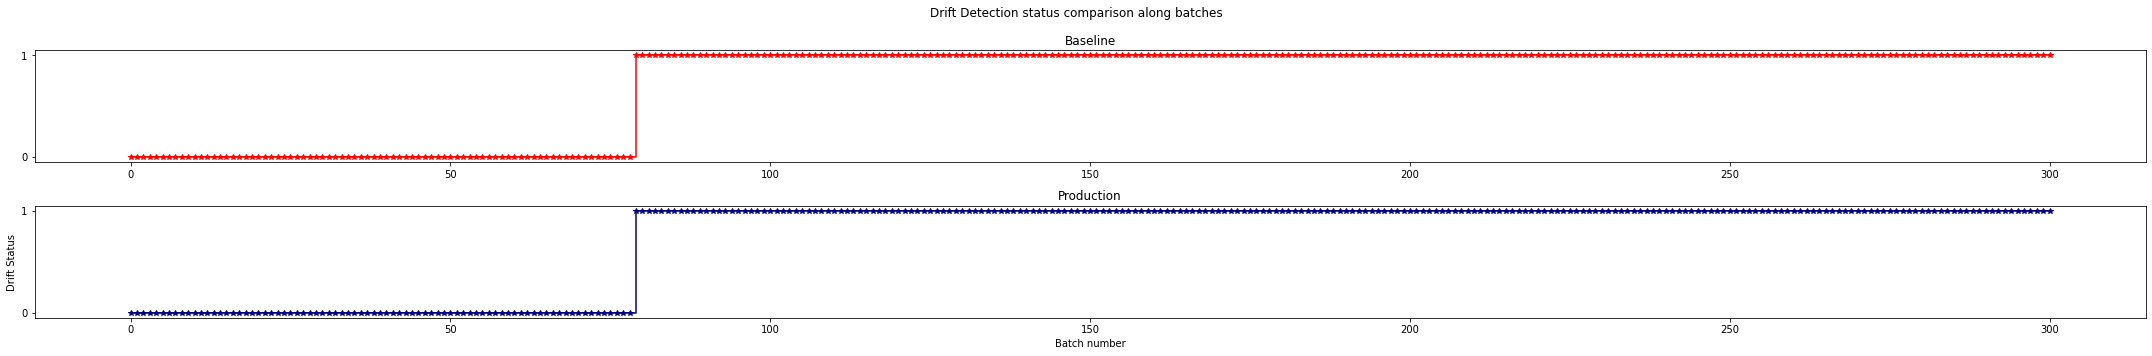

In [12]:
plutils.show_drift_detection_step(perf_kpis_base,perf_kpis_prod,title='Drift Detection status comparison along batches')

In [13]:
print('BASELINE')
perf_kpis_base

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.934515,0.910868,1.520734,1.520734,2.072736,0.0,[],NaN
2,0.793339,0.718711,2.188752,2.188752,4.017503,0.0,[],NaN
3,0.933394,0.909342,1.888791,1.888791,2.922534,0.0,[],NaN
4,0.752020,0.662472,2.161540,2.161540,4.185094,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,0.253382,-0.016230,6.660412,6.660412,8.588722,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN
297,-0.059911,-0.442657,5.482452,5.482452,6.248694,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN
298,-0.283498,-0.746983,6.160412,6.160412,7.338966,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN
299,0.385356,0.163401,7.055008,7.055008,8.855522,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN


In [14]:
print('PRODUCTION')
perf_kpis_prod

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.934515,0.910868,1.520734,1.520734,2.072736,False,[],False
2,0.793339,0.718711,2.188752,2.188752,4.017503,False,[],False
3,0.933394,0.909342,1.888791,1.888791,2.922534,False,[],False
4,0.752020,0.662472,2.161540,2.161540,4.185094,False,[],False
...,...,...,...,...,...,...,...,...
296,0.253382,-0.016230,6.660412,6.660412,8.588722,True,"[ks_RM, ks_LSTAT, chi_CHAS]",False
297,-0.059911,-0.442657,5.482452,5.482452,6.248694,True,"[ks_RM, ks_LSTAT, chi_CHAS]",False
298,-0.283498,-0.746983,6.160412,6.160412,7.338966,True,"[ks_RM, ks_LSTAT, chi_CHAS]",False
299,0.385356,0.163401,7.055008,7.055008,8.855522,True,"[ks_RM, ks_LSTAT, chi_CHAS]",False


## Summary Results

Should be the same for both

In [15]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[-1]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[-1]['RMSE']))


Initial Baseline RMSE on test set: 2.7572
Initial Production RMSE on test set: 2.7572
**************************************************
Final Baseline RMSE on test set: 7.9572
Final Production RMSE on test set: 7.9572


# Runtime 2 - Inference Drift Detection (with retraining)

In [16]:
%%time

# Init fresh start
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2,baseline_model2,production_model2 = \
            plutils.init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2,X_noisy,y_noisy = \
      run_drift_demo(X,y,number_of_batches=300,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model2,drift_detector=drift_detector2,perf_kpis_prod=perf_kpis_prod2,
                   baseline_model=baseline_model2,baseline_drift_detector=base_drift_detector2,
                   perf_kpis_base=perf_kpis_base2,retrain_on_drift=True,sample_size=100,
                   noise_factor=ds_categ_noise_factor,numeric_noise_factor=ds_numeric_noise_factor,x_cat_features=x_cat_features)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 27.9 s, sys: 634 ms, total: 28.5 s
Wall time: 28.4 s


## Plot RMSE for Baseline vs. Production

Drift Detected and automatically handled by retraining

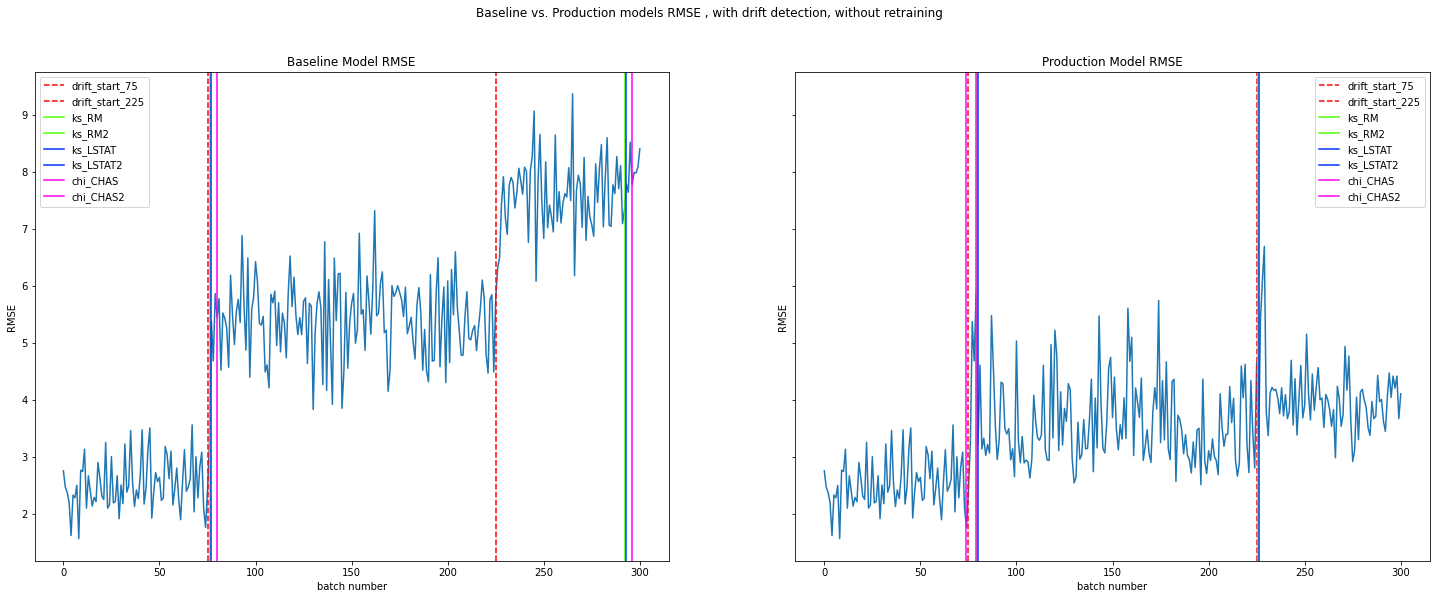

In [17]:
fig, axs = plt.subplots(1,2,figsize=(25, 9),sharey=True)
plutils.display_run(perf_kpis_base2,base_drift_detector2,start_drift_at_batch,axs[0],title='Baseline Model RMSE',smoothen=False)
plutils.display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs[1],title='Production Model RMSE',smoothen=False)
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

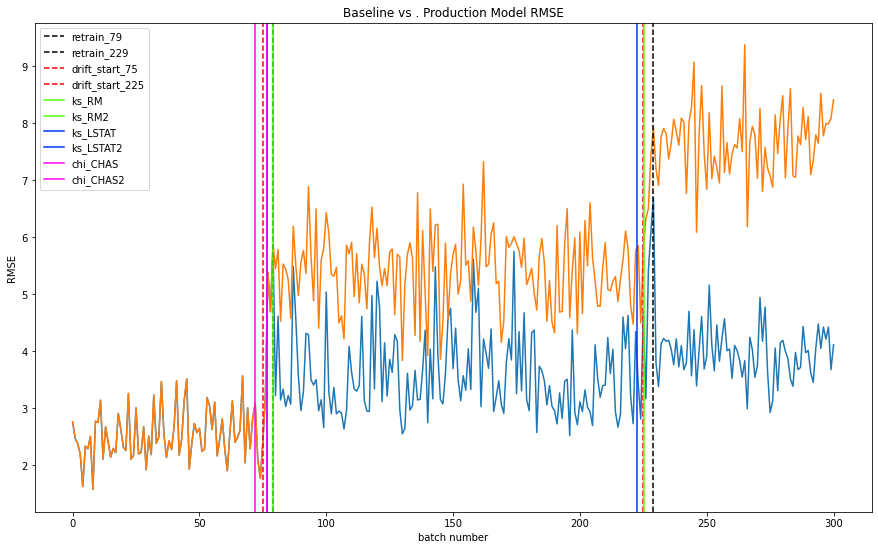

In [18]:
fig, axs = plt.subplots(1,1,figsize=(15, 9))
plutils.display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs,title='Baseline vs . Production Model RMSE',
            baseline_perf_kpis=perf_kpis_base2,show_train=True,
            smoothen=False)
            # smoothen=True)
plt.show()

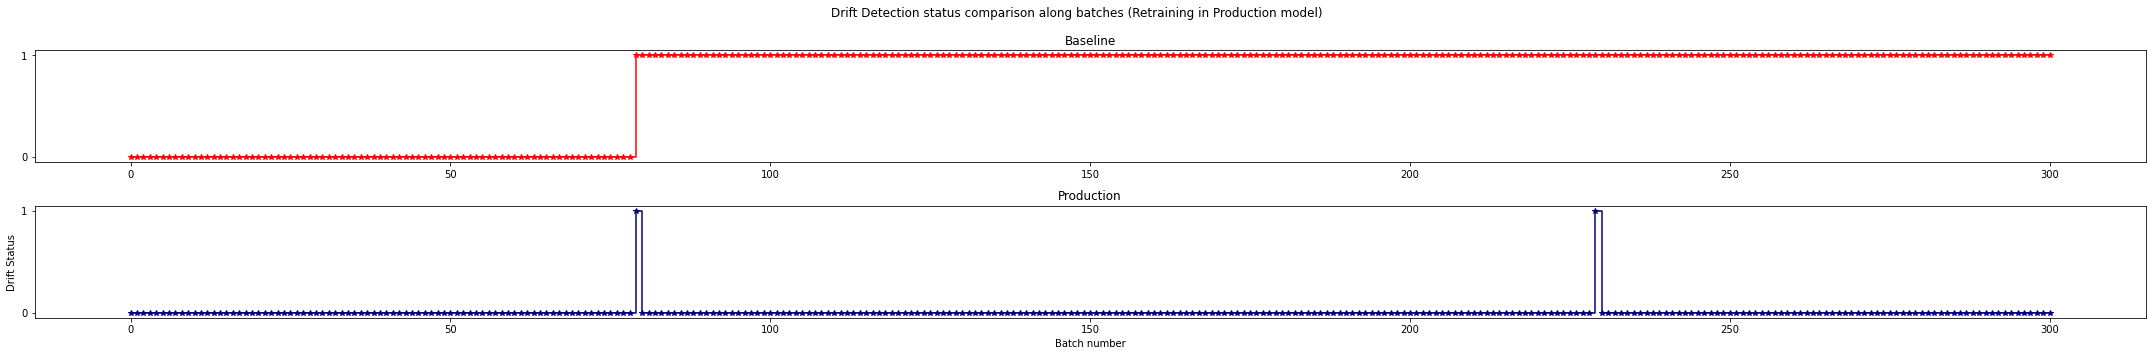

In [19]:
plutils.show_drift_detection_step(perf_kpis_base2,perf_kpis_prod2,title='Drift Detection status comparison along batches (Retraining in Production model)')

In [20]:
print('BASELINE'),display(perf_kpis_base2)

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.909497,0.895816,1.739205,1.739205,2.469961,0.0,[],NaN
2,0.923415,0.911839,1.661848,1.661848,2.376290,0.0,[],NaN
3,0.946517,0.938432,1.481430,1.481430,2.196008,0.0,[],NaN
4,0.964010,0.958570,1.243073,1.243073,1.622120,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,0.238640,0.123551,6.484696,6.484696,7.774851,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN
297,0.353384,0.255639,6.402208,6.402208,7.990294,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN
298,0.204405,0.084141,6.539363,6.539363,7.982297,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN
299,0.242361,0.127834,6.441264,6.441264,8.082856,1.0,"[ks_RM, ks_LSTAT, chi_CHAS]",NaN


(None, None)

In [21]:
print('PRODUCTION'),display(perf_kpis_prod2)

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.909497,0.895816,1.739205,1.739205,2.469961,False,[],False
2,0.923415,0.911839,1.661848,1.661848,2.376290,False,[],False
3,0.946517,0.938432,1.481430,1.481430,2.196008,False,[],False
4,0.964010,0.958570,1.243073,1.243073,1.622120,False,[],False
...,...,...,...,...,...,...,...,...
296,0.753927,0.716730,3.098444,3.098444,4.420067,False,[],False
297,0.820619,0.793503,3.039175,3.039175,4.208508,False,[],False
298,0.756095,0.719225,2.898165,2.898165,4.419698,False,[],False
299,0.843506,0.819850,2.696343,2.696343,3.673516,False,[],False


(None, None)

## Summary Results

In [22]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[-50]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[-50]['RMSE']))

Initial Baseline RMSE on test set: 2.7572
Initial Production RMSE on test set: 2.7572
**************************************************
Final Baseline RMSE on test set: 8.1777
Final Production RMSE on test set: 5.1545


In [23]:
plutils.report_summary_kpi(perf_kpis_base2,perf_kpis_prod2,selected_dataset=selected_dataset)

Average RMSE on last 50 batches: Baseline:8.1777 vs. Production:5.1545
Production model is better by 3.0232 , a potential saving of 3023.21$ for the house predictions company


# NannyML DLE - RMSE Estimate

Additional independent estimate of the production model RMSE

In [24]:
base_df = X.copy()
prod_df = X_noisy.copy()
#baseline model on noisy data
base_df['y_true'] = y.copy()
base_df['y_pred'] = production_model2.predict(X)
#retrained model on noisy data
prod_df['y_pred'] = production_model2.predict(X_noisy)
base_df.shape,prod_df.shape

((2530, 15), (30100, 14))

In [25]:
import nannyml as nml
from IPython.display import display

# the DF for training the nanny model
reference_df = base_df
# a DF for the RMSE estimation of the nanny model
analysis_df = prod_df
estimator = nml.DLE(
    feature_column_names=x_cont_features+x_int_features+x_cat_features,
    y_pred='y_pred',
    y_true='y_true',
    # timestamp_column_name='timestamp',
    metrics=['rmse'],
    chunk_size=600,
    tune_hyperparameters=False
)

estimator.fit(reference_df)

results = estimator.estimate(analysis_df)
display(results.filter(period='analysis').to_df())

display(results.filter(period='reference').to_df())

metric_fig = results.plot()
metric_fig.show()




chunk                                                        \
              key chunk_index start_index end_index start_date end_date   
0         [0:599]           0           0       599       None     None   
1      [600:1199]           1         600      1199       None     None   
2     [1200:1799]           2        1200      1799       None     None   
3     [1800:2399]           3        1800      2399       None     None   
4     [2400:2999]           4        2400      2999       None     None   
5     [3000:3599]           5        3000      3599       None     None   
6     [3600:4199]           6        3600      4199       None     None   
7     [4200:4799]           7        4200      4799       None     None   
8     [4800:5399]           8        4800      5399       None     None   
9     [5400:5999]           9        5400      5999       None     None   
10    [6000:6599]          10        6000      6599       None     None   
11    [6600:7199]          11        6600      7199       None     None   
12    [7200:7799]          12        7200      7799       None     None   
13    [7800:8399]          13        7800      8399       None     None   
14    [8400:8999]          14        8400      8999       None     None   
15    [9000:9599]          15        9000      9599       None     None   
16   [9600:10199]          16        9600     10199       None     None   
17  [10200:10799]          17       10200     10799       None     None   
18  [10800:11399]          18       10800     11399       None     None   
19  [11400:11999]          19       11400     11999       None     None   
20  [12000:12599]          20       12000     12599       None     None   
21  [12600:13199]          21       12600     13199       None     None   
22  [13200:13799]          22       13200     13799       None     None   
23  [13800:14399]          23       13800     14399       None     None   
24  [14400:14999]          24       14400     14999       None     None   
25  [15000:15599]          25       15000     15599       None     None   
26  [15600:16199]          26       15600     16199       None     None   
27  [16200:16799]          27       16200     16799       None     None   
28  [16800:17399]          28       16800     17399       None     None   
29  [17400:17999]          29       17400     17999       None     None   
30  [18000:18599]          30       18000     18599       None     None   
31  [18600:19199]          31       18600     19199       None     None   
32  [19200:19799]          32       19200     19799       None     None   
33  [19800:20399]          33       19800     20399       None     None   
34  [20400:20999]          34       20400     20999       None     None   
35  [21000:21599]          35       21000     21599       None     None   
36  [21600:22199]          36       21600     22199       None     None   
37  [22200:22799]          37       22200     22799       None     None   
38  [22800:23399]          38       22800     23399       None     None   
39  [23400:23999]          39       23400     23999       None     None   
40  [24000:24599]          40       24000     24599       None     None   
41  [24600:25199]          41       24600     25199       None     None   
42  [25200:25799]          42       25200     25799       None     None   
43  [25800:26399]          43       25800     26399       None     None   
44  [26400:26999]          44       26400     26999       None     None   
45  [27000:27599]          45       27000     27599       None     None   
46  [27600:28199]          46       27600     28199       None     None   
47  [28200:28799]          47       28200     28799       None     None   
48  [28800:29399]          48       28800     29399       None     None   
49  [29400:30099]          49       29400     30099       None     None   

                       rmse                                               \
      period sampling_error realize

chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0      [0:599]           0           0       599       None     None   
1   [600:1199]           1         600      1199       None     None   
2  [1200:1799]           2        1200      1799       None     None   
3  [1800:2529]           3        1800      2529       None     None   

                       rmse                                                \
      period sampling_error  realized     value upper_confidence_boundary   
0  reference       0.197449  2.513518  2.525327                  3.117675   
1  reference       0.197449  2.559054  2.588606                  3.180953   
2  reference       0.197449  2.652427  2.642035                  3.234382   
3  reference       0.179007  2.708927  2.685063                  3.222084   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  1.932979        2.838337        2.378625  False  
1                  1.996258        2.838337        2.378625  False  
2                  2.049687        2.838337        2.378625  False  
3                  2.148043        2.838337        2.378625  False